# <font style="color:rgb(50,120,229)"> EE5/7382 – Fundamentals of Computer Vision - Homework 2 Solutions
</font>

##### **<font color="red">Hybrid Images (5+5+10+5)=25 points</font>**
In this assignment, you will be implementing ideas described by Oliva, Torralba, and Schyns in their 2006 SIGGRAPH paper on Hybrid Images (http://cvcl.mit.edu/publications/OlivaTorralb_Hybrid_Siggraph06.pdf). The paper argues that high frequency image content (texture, detail and edges) tends to dominate human visual perception at closer distances. In contrast, at farther distances, only low frequency (smooth) image content is perceived. By blending high and low frequency content, it is possible to create a hybrid image that is perceived differently at different distances/scales.  
<br>
##### <font color="cyan">What are Hybrid Images?</font>
A hybrid image is the weighted superposition (blending) of a blurry (low-pass filtered) version of a first image ($i_1$) and a high-pass filtered version of a second image ($i_2$). A blurred representation of the first image is obtained by applying a Gaussian filter $h_\sigma$ with an appropriately chosen value of $\sigma$. The high-pass version of the second image is obtained by subtracting a blurred representation of the image ($i_2\otimes h_\sigma$) from the image $i_2$. 
<br><br>
<u>NOTE:</u> In the original paper, the filtering operations are implemented in the Fourier domain. For the purpose of this assignment, we will however restrict attention to filtering in the spatial domain.
 
The expression for the hybrid image is disclosed below
$
\begin{equation}
    \mathtt{Hybrid\hspace{0.1in}Image} \hspace{0.1in} = \hspace{0.1in} \alpha [i_1 \otimes h_\sigma] \hspace{0.1in} + \hspace{0.1in} (1-\alpha) [i_2 - (i_2 \otimes h_\sigma)]
\end{equation}
$

* The parameter $\alpha$ controls the blend ratio and is typically a number between 0 & 1. Start with a value of 0.5.
* The filter $h_\sigma$ is a Gaussian kernel with a standard deviation of $\sigma$ pixels. Ensure that the filter size is an ODD integer.
* The term $[i_1\otimes h_\sigma]$ represents the blurred or low-pass representation of image-1. 
* The term $i_2-[i_2\otimes h_\sigma]$ represents the high-pass representation of image-2.


##### <font color="yellow">Preamble</font>

In [161]:
# Preamble
import cv2 as cv
import sys
import matplotlib.pyplot as plt
import numpy as np

#### <font color="yellow">Helper functions</font>

In [162]:
# Helper functions
def im2double(im):
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(float) / info.max # Divide all values by the largest possible value in the datatype

# Helper function to visualize hybrid image
# Adapted from MATLAB code provided by Prof. James Hays
def visualize_HyrbidImage(im_hybrid):
    scales = 5
    scale_factor = 0.6
    
    im_output = im_hybrid
    sz = im_hybrid.shape

    arr2D = im_hybrid
    for nn in np.arange(1,scales,1):
        numRows = int( sz[0] * scale_factor**nn )     # width
        numCols = int( sz[1] * scale_factor**nn )     # height
        #
        if numRows==0 or numCols==0:
            break
        #        
        arr2D = cv.resize(im_hybrid,[numCols,numRows],interpolation = cv.INTER_AREA)
        arr2D_pad = cv.copyMakeBorder( arr2D, sz[0] - numRows, 0, 20, 0, cv.BORDER_CONSTANT, None, 0 )
        #
        im_output = np.hstack( (im_output, arr2D_pad) )

    # Write image to disk 
    # The array im_output will likely have positive and negative values
    # Re-scale the intensity range so the smallest value maps to 0 and the largest value maps to 1
    # Now multiply the result by 255 and store in 8-bit image  
    mnVal = np.min(im_output)
    mxVal = np.max(im_output)
    im_output_nrmlzd = 255 * (im_output - mnVal)/(mxVal - mnVal)
    cv.imwrite("Hybrid_Image.png", im_output_nrmlzd.astype(int) )
    
    # Display using OpenCV built-in function
    cv.imshow('Hyrbid Image Visualization', im_output)
    cv.waitKey(0)
    cv.destroyAllWindows() 
    return 
    

###### What do you think the helper function `visualize_HybridImage()` is trying to do?

#### <font color="yellow">Read the grayscale images using imread and convert to double using `im2double` (5 points)</font>

In [163]:
fileName1 = ('dog.bmp','einstein.bmp','bird.bmp')
fileName2 = ('cat.bmp','marilyn.bmp','plane.bmp')
pairNum = 0

dirPath = ".\\Data_HybridImages\\"

# Assemble the filenames for a given pair number by appending dirPath 
# with the appropriate entry in fileName1 and fileName2 

# Read in Grayscale mode
im1 = cv.imread( dirPath + fileName1[pairNum] , cv.IMREAD_GRAYSCALE )
im2 = cv.imread( dirPath + fileName2[pairNum] , cv.IMREAD_GRAYSCALE )

# Convert to double using im2double()
im1 = im2double(im1)
im2 = im2double(im2)

#### <font color="yellow">Zero pad the images so that they have the same size (5 points)</font>
It helps if the number of rows & columns in each image is an ODD integer. 
The starter code does this for you.

In [164]:
# Compute the size of each image
sz1 = im1.shape
sz2 = im1.shape

# Check if the size of each image is ODD. If not make ODD
new_sz1 = sz1 - ( 1 - np.mod(sz1,2) )
new_sz2 = sz2 - (1 - np.mod(sz2,2) )

# Crop the images so they have ODD number of rows & columns
im1 = im1[ 0:new_sz1[0] , 0:new_sz1[1] ]
im2 = im2[ 0:new_sz2[0] , 0:new_sz2[1] ]

# Code to compute size of image after cropping
sz1 = im1.shape
sz2 = im1.shape

# If the image sizes are different zero pad the smaller image so that their sizes match
# Your code goes here
sz_hybrid = [ np.maximum(sz1[0],sz2[0]) , np.maximum(sz1[1],sz2[1]) ]

# Zero pad each image so its size matches sz_hybrid
numRows2Pad = sz_hybrid[0] - sz1[0]     # should be odd
numCols2Pad = sz_hybrid[1] - sz1[1]     # should be odd
pr_by_2 = np.around(0.5 * numRows2Pad).astype(int) 
pc_by_2 = np.around(0.5 * numCols2Pad).astype(int)
im1 = cv.copyMakeBorder( im1, pr_by_2, pr_by_2, pc_by_2, pc_by_2, cv.BORDER_CONSTANT, None, 0 )
im2 = cv.copyMakeBorder( im2, pr_by_2, pr_by_2, pc_by_2, pc_by_2, cv.BORDER_CONSTANT, None, 0 )

###### At this point the images `im1` and `im2` must have the same size. Furthermore, the number of rows & columns in each image must be ODD.

#### <font color="yellow">Pick parameters associated with the generation of hybrid images </font>
See https://ipython-books.github.io/33-mastering-widgets-in-the-jupyter-notebook/ for help

In [165]:
# Standard deviation of Gaussian blur kernel
sigma = 7.5 # Pick something in the range (0.5-5)
    
# Blend ratio
alpha = 0.5     # alpha < 0.5 emphasizes high-pass

#### <font color="yellow">Generate the hybrid image (10 points)</font>
* Blur `im1` using a Gaussian kernel with standard deviation $\sigma$ to obtain `im1_blurred`
* Blur `im2` using a Gaussian kernel with standard deviation $\sigma$ to obtain `im2_blurred`
* Implement Eq.(1)
* Display the original images and the hybrid image in a figure window
* Experiment with different choices of $\sigma$ and $\alpha$
<br>
<br>
Furnish your code here  

In [166]:
fltSize = np.ceil(6*sigma).astype(int)      # round to integer just larger than 6*sigma
fltSize = fltSize + (1-np.mod(fltSize,2))   # round to nearest odd integer

im1_lowpass = cv.GaussianBlur( im1,(fltSize,fltSize),sigma )
im2_lowpass = cv.GaussianBlur( im2,(fltSize,fltSize),sigma )
im2_highpass = im2 - im2_lowpass

im_hybrid = (alpha * im1_lowpass) + ( (1-alpha)*(im2_highpass) )


#### <font color="yellow">Visualize the output</font>

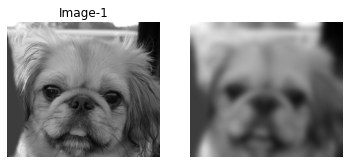

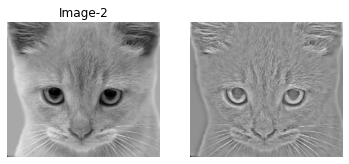

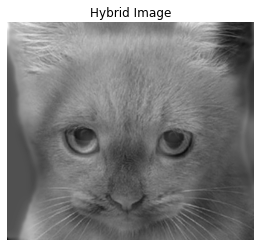

In [167]:
# Display the first image & its low-pass version side-by-side in a new figure
# Use plt.axis('off') to suppress the display of coordinate axes
f = plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1,cmap='gray')            
plt.title('Image-1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im1_lowpass,cmap='gray')    
plt.axis('off')

# Display the second image & its high-pass version side-by-side in a new figure
f = plt.figure()
plt.subplot(1,2,1)
plt.imshow(im2,cmap='gray')    
plt.title('Image-2')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im2_highpass,cmap='gray') 
plt.axis('off')

# Display the hybrid image in a new figure
f = plt.figure()
plt.imshow(im_hybrid,cmap='gray')    
plt.title('Hybrid Image')
plt.axis('off')

# Visualize the hybrid image @ multiple scales using the function 
visualize_HyrbidImage(im_hybrid)
